
## 1D HEAT EQUATION
### ADVECTION–DIFFUSION, MOVING SURFACE

∂T/∂t + w(z,t) ∂T/∂z = κ ∂²T/∂z²

#### BCs:
- z = 0:      -k ∂T/∂z = q_g            (Neumann/flux; implicit)
- z = H(t):    T = T_S(t)               (Dirichlet; implicit)


#### Time stepping:
- Diffusion: Crank–Nicolson
- Advection: fully implicit, 1st-order upwind (per-node wind direction)
- Moving grid handled by re-interpolation each step


In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

In [2]:
# --- physical parameters ---
kappa = 1e-6         # thermal diffusivity [m²/s]
k = 2.1              # thermal conductivity [W/m/K]
q_g = 0.05           # geothermal flux [W/m²]
# rho, c = 900, 2000   # not used explicitly here

# --- time setup ---
years = 20_000                        # total sim time [yr]
sec_per_yr = 365*24*3600
t_final = 2025 * sec_per_yr
t_start = -30_000 * sec_per_yr
dt = 1.0e9                            # ~31.7 yr
nt = int((t_final - t_start) // dt)

# --- spatial grid (updated each step to match H(t)) ---
nz = 51

# --- time-dependent functions (edit to taste) ---
def H(t):
    """Surface elevation [m]."""
    return 3500.0 - 0.02 * (t / sec_per_yr)  # 20 m per kyr lowering

def T_surf(t):
    """Surface temperature [°C]. Glacial cooling example."""
    # Smooth step from -5°C (early) to -15°C (late)
    lgm_year = -20_000  # year of Last Glacial Maximum
    half_change = 5
    T_midpoint = -36
    return T_midpoint - half_change*np.tanh(-((t- lgm_year*sec_per_yr)/(1_000*sec_per_yr) - 1))

def a_rate(t):
    """Accumulation rate [m/s]; allow time variation if desired."""
    return 0.2 / sec_per_yr  # 0.1 m/yr constant

def w_profile(z, t):
    """Vertical velocity [m/s], positive upward: w = a(t) * z / H(t)."""
    return -a_rate(t) * z / max(H(t), 1e-12)

from scipy.special import erfi

# --- analytical steady-state temperature profile ---
def steady_temp_profile(z, H, a, kappa, k, q_g, T_s):
    """
    Steady-state glacier temperature profile for w(z) = -(a z / H).
    z = 0 at bed, z = H at surface.
    """
    z = np.asarray(z, float)
    beta = a / (2.0 * kappa * H)
    if np.isclose(beta, 0.0):
        return T_s + (q_g / k) * (H - z)
    rootb = np.sqrt(beta)
    pref = (q_g / k) * np.sqrt(np.pi) / (2.0 * rootb)
    return T_s + pref * (erf(rootb*H) - erf(rootb*z))


# --- initial condition on initial grid ---
z = np.linspace(0.0, H(0.0), nz)
# T = (H(0.0)-z)*q_g/k + T_surf(0.0)  # linear IC from BCs
T = steady_temp_profile(z, H(0.0), a_rate(0.0), kappa, k, q_g, T_surf(0.0))

# --- allocate storage for full solution ---
T_all = np.zeros((nz, nt+1))
z_all = np.zeros((nz, nt+1))
t_all = t_start + np.arange(nt+1) * dt
T = steady_temp_profile(z, H(0.0), a_rate(0.0), kappa, k, q_g, T_surf(0.0))
T_all[:, 0] = T
z_all[:, 0] = z

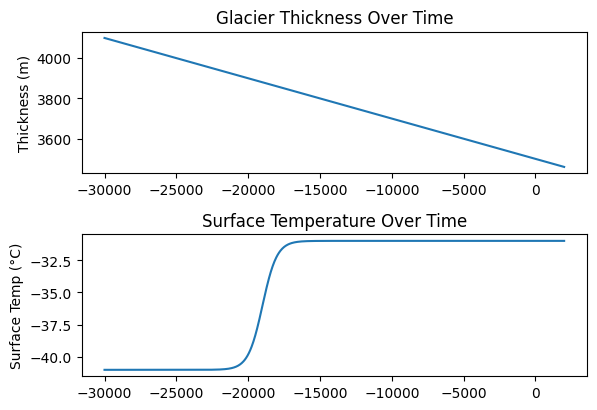

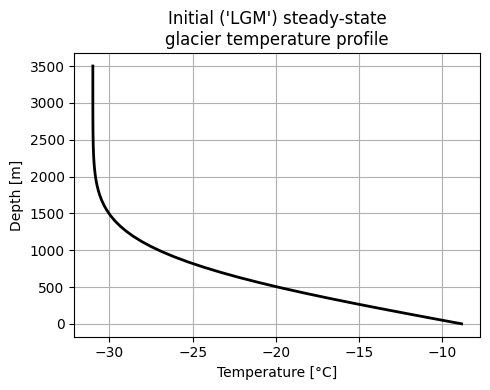

In [3]:
# Plot the thickness, surface temperature, and accumulation rate over time
import matplotlib.pyplot as plt 

plt.figure(figsize=(6, 6))

plt.subplot(3, 1, 1)
plt.plot(t_all / sec_per_yr, H(t_all))
plt.ylabel('Thickness (m)')
plt.title('Glacier Thickness Over Time')

plt.subplot(3, 1, 2)
plt.plot(t_all / sec_per_yr, T_surf(t_all))
plt.ylabel('Surface Temp (°C)')
plt.title('Surface Temperature Over Time')

# plt.subplot(3, 1, 3)
# plt.plot(t_all / sec_per_yr, a_rate(t_all) * sec_per_yr)
# plt.xlabel('Time (years)')
# plt.ylabel('Accumulation Rate (m/yr)')
# plt.title('Accumulation Rate Over Time')

plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
plt.plot(T, z, 'k', lw=2)
plt.xlabel("Temperature [°C]")
plt.ylabel("Depth [m]")
plt.title("Initial ('LGM') steady-state\nglacier temperature profile")
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
def assemble_system(z, T_prev, t, dt, kappa, q_g, k, cap_temp=True):
    """
    Assemble linear system A*T_new = rhs for one CN + implicit-upwind step.
    Optionally caps temperatures at 0°C before building system.

    Parameters
    ----------
    z : ndarray
        Spatial grid [m].
    T_prev : ndarray
        Temperature field at previous step [°C].
    t : float
        Current time [s].
    dt : float
        Time step [s].
    kappa : float
        Thermal diffusivity [m²/s].
    q_g : float
        Geothermal heat flux [W/m²].
    k : float
        Thermal conductivity [W/m/K].
    cap_temp : bool, default=True
        If True, cap T at 0°C before computing advection/diffusion.
    """
    nz = len(z)
    dz = np.diff(z)[0]
    r = kappa * dt / (2.0 * dz**2)

    # --- cap temperatures at melting point ---
    if cap_temp:
        T_prev = np.minimum(T_prev, 0.0)

    # Matrices
    A = np.zeros((nz, nz))
    B = np.zeros((nz, nz))

    # Build interior rows (1..nz-2)
    w = w_profile(z, t)  # vertical velocity profile [m/s]

    for i in range(1, nz-1):
        # Diffusion (Crank–Nicolson)
        A[i, i-1] += -r
        A[i, i  ] +=  1 + 2*r
        A[i, i+1] += -r

        B[i, i-1] +=  r
        B[i, i  ] +=  1 - 2*r
        B[i, i+1] +=  r

        # Advection (fully implicit, upwind)
        wi = w[i]
        if wi >= 0.0:
            A[i, i  ] += dt * wi / dz
            A[i, i-1] += -dt * wi / dz
        else:
            A[i, i+1] +=  dt * wi / dz
            A[i, i  ] += -dt * wi / dz

    # --- Boundary conditions ---
    # Bottom: -k (T[1]-T[0])/dz = q_g  -> T[0] - T[1] = q_g*dz/k
    A[0,0] =  1.0
    A[0,1] = -1.0
    rhs0 = q_g * dz / k

    # Surface: T = T_surf(t+dt)
    A[-1,-1] = 1.0
    rhsN = T_surf(t + dt)

    # --- RHS ---
    rhs = B @ T_prev
    rhs[0]  = rhs0
    rhs[-1] = rhsN

    # --- optional cap after forming RHS (safety) ---
    if cap_temp:
        rhs = np.minimum(rhs, 0.0)

    return A, rhs


In [5]:
# --- main time loop ---
for n in range(nt):
    t = t_all[n]

    # Move grid to new surface height and interpolate T
    z_new = np.linspace(0.0, H(t + dt), nz)
    T     = np.interp(z_new, z, T)
    z     = z_new
    z_all[:, n+1] = z

    # Assemble and solve
    A, rhs = assemble_system(z, T, t, dt, kappa, q_g, k, cap_temp=False)
    T = np.linalg.solve(A, rhs)

    # Save
    T_all[:, n+1] = T

# ------------------------------------------------------------
# Outputs:
#   T_all[z_index, t_index]  -> temperature [°C]
#   z_all[z_index, t_index]  -> depth grid [m]
#   t_all[t_index]           -> time [s]
# ------------------------------------------------------------
print("Done. Arrays available: T_all, z_all, t_all")
print(f"Final H = {H(t_all[-1]):.2f} m, Final T_surf = {T_surf(t_all[-1]):.2f} °C")


Done. Arrays available: T_all, z_all, t_all
Final H = 3460.10 m, Final T_surf = -31.00 °C


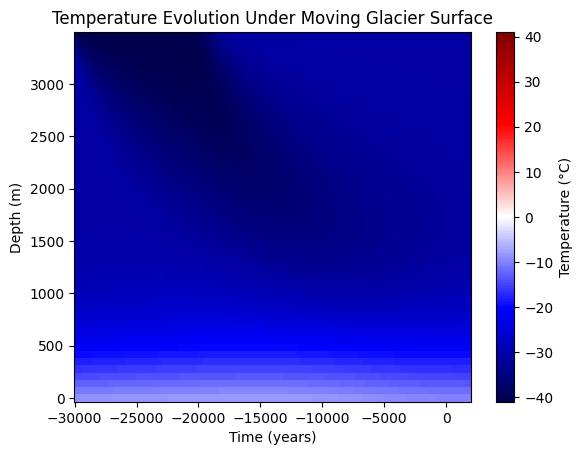

In [6]:
import matplotlib.pyplot as plt
plt.pcolormesh(t_all/sec_per_yr,z,T_all,cmap='seismic',vmin=np.min(T_all), vmax=-np.min(T_all))
plt.colorbar(label='Temperature (°C)')
plt.xlabel('Time (years)')
plt.ylabel('Depth (m)')
plt.title('Temperature Evolution Under Moving Glacier Surface')
plt.show()

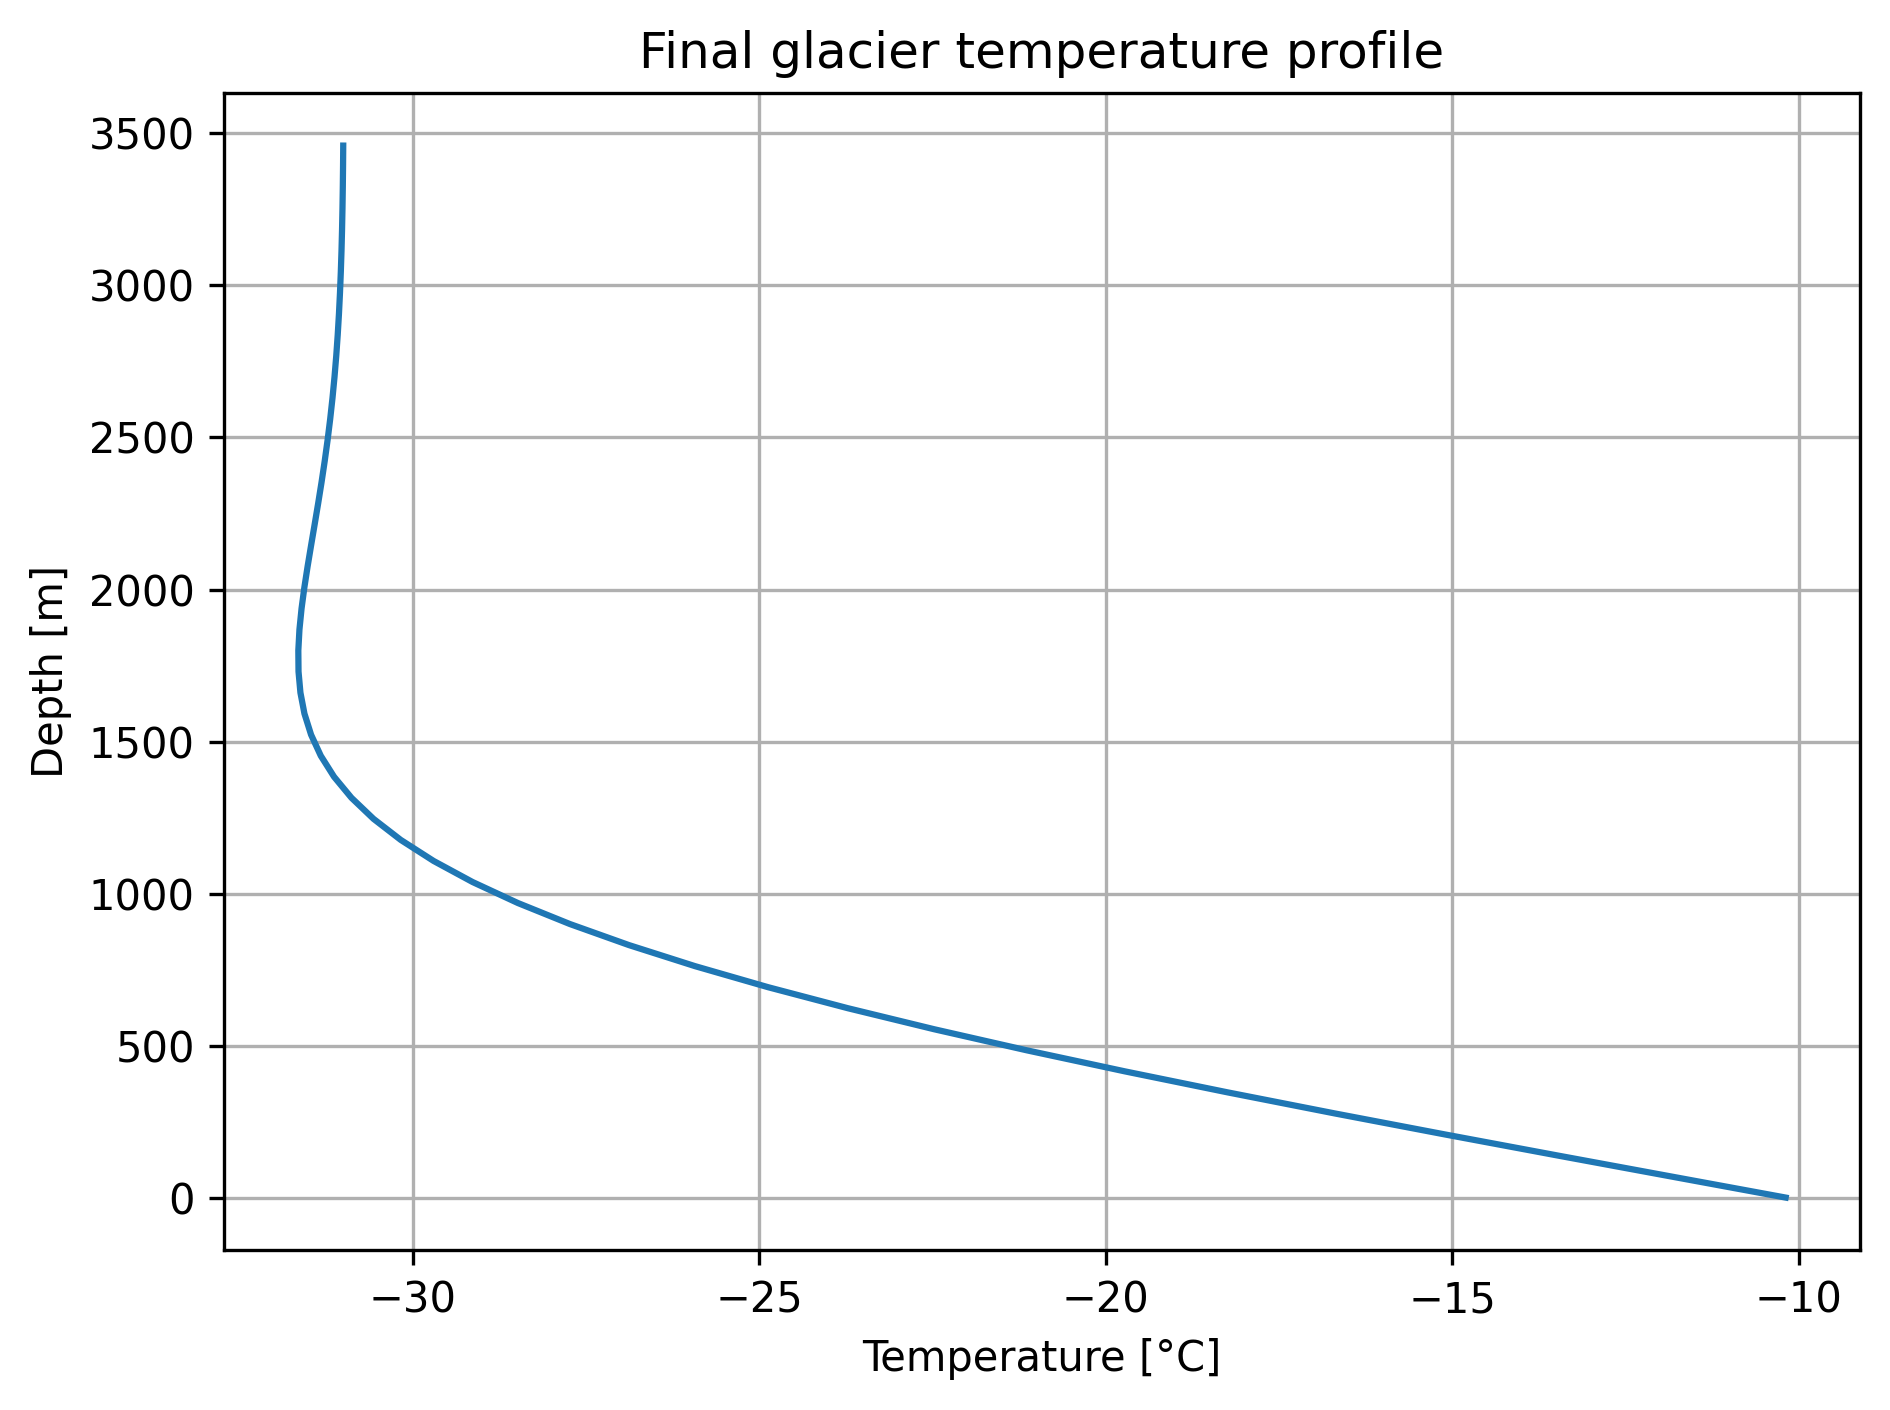

In [8]:
plt.subplots(dpi=300)
plt.plot(T_all[:,-1],z)
plt.xlabel("Temperature [°C]")
plt.ylabel("Depth [m]")
plt.title("Final glacier temperature profile")
plt.grid(True)
plt.tight_layout()
plt.show()